# ClaraFold: Prediction of RNA secondary structures including pseudoknots using Transformers (training pipeline)

Date: 2025-05-31
**Version:** 1.0

---

## Notebook description

This notebook contains the full training pipeline for cross-family RNA structure prediction using a Transformer-based model. The pipeline includes:

- Data preparation
- Tokenization and vocabulary building
- Model architecture definition
- Model training and distributed orchestration
- Model checkpointing and evaluation
- Loss visualization and diagnostics

**Important setup instructions:**

- This notebook is designed to run with GPU acceleration.
- Before running any cells:
  1. Go to the menu: **Runtime → Change runtime type**
  2. In the **Hardware accelerator** dropdown, select **GPU**
  3. Click **Save**
- After changing the runtime, please re-run all the setup cells below to reinstall packages and check the environment.

> Note: Google Colab sessions are ephemeral. Every time you restart the runtime, all installations and files are cleared.

## Table of contents

>[ClaraFold: Prediction of RNA secondary structures including pseudoknots using Transformers (training pipeline)](#scrollTo=2A-Sa-earPNO)

>>[Notebook description](#scrollTo=2A-Sa-earPNO)

>>[Table of contents](#scrollTo=ug3Lor7_Fef8)

>>>[Package installation](#scrollTo=Inhro9kJn3ek)

>>>[Environment check: Python, GPU, and CUDA](#scrollTo=jyzmeSuCpvLv)

>>>[Mount Google Drive](#scrollTo=9pkYgNE-vswj)

>>[Model architecture and training utilities](#scrollTo=ZBhkbS0b5K5U)

>>[Dataset preparation](#scrollTo=dBQcBBJi0apk)

>>>[Dataset preparation: cross-family data split (Fold 1)](#scrollTo=dBQcBBJi0apk)

>>>[Sanity check: pairwise sequence length consistency](#scrollTo=yTu-8Q9x12VA)

>>>[Save datasets to files](#scrollTo=hozqu5s22zsX)

>>>[Export data splits to individual files](#scrollTo=xmL4_sMs3YZX)

>>>[Data split inspection](#scrollTo=OtbHccGs5QDp)

>>[Tokenization, vocabulary building, and token length analysis](#scrollTo=AhhVHEmb7DJy)

>>>[Vocabulary summary](#scrollTo=F2KUZxxc7dwT)

>>>[Vocabulary content inspection and token length distribution](#scrollTo=YJhZfXCa0iBu)

>>>[Load saved vocabularies](#scrollTo=FST6J5R81wwy)

>>[DataLoaders and Batching](#scrollTo=x-L3hYwY2ZOP)

>>>[Batch collation and padding](#scrollTo=x-L3hYwY2ZOP)

>>>[DataLoader creation for training and validation](#scrollTo=UpfPWpQC2jqY)

>>[Model training pipeline](#scrollTo=FUP-7PZ-27u6)

>>>[Model training loop](#scrollTo=FUP-7PZ-27u6)

>>>[Distributed training orchestration](#scrollTo=87GAE8Zb3dNR)

>>[Model loading and (re-)training logic](#scrollTo=K5c8ejDO4AxU)

>>>[Conditional model loading for interactive notebook sessions](#scrollTo=Eyk5V2F34dJq)

>>[Training history analysis and loss visualization](#scrollTo=LZ8WF39W7rF2)

>>>[Loss visualization](#scrollTo=LZ8WF39W7rF2)

>>>[Retrieve filename of the best model checkpoint](#scrollTo=B98oTH3-7xGL)



### Package installation

This notebook requires the following Python packages:

- **torch (2.0.1)**
- **torchtext (0.15.2)**
- **torchdata (0.6.1)**
- **folium (0.2.1)**
- **altair**
- **GPUtil**


In [ ]:
!pip install -q torch==2.0.1 torchtext==0.15.2 torchdata==0.6.1 folium==0.2.1 altair GPUtil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

### Environment check: Python, GPU, and CUDA

This cell displays the current runtime environment, including:

- Python version
- PyTorch version
- GPU availability and specifications (using GPUtil)
- CUDA availability and version (using PyTorch)

> This information helps verify that the runtime is correctly configured before running experiments.

In [ ]:
# Environment Check

# Check Python version
import sys
print("Python version:", sys.version)

# Check Torch version
import torch
print("Torch version:", torch.__version__)

# Check GPU information using GPUtil
import GPUtil

try:
    gpus = GPUtil.getGPUs()
    if not gpus:
        print("\nGPU information: No GPUs detected by GPUtil.")
    else:
        print("\nGPU information:")
        for gpu in gpus:
            print(f"\tName: {gpu.name}")
            print(f"\tID: {gpu.id}")
            print(f"\tTotal Memory: {gpu.memoryTotal} MB")
except Exception as e:
    print("Could not retrieve GPU information:", e)

# Check CUDA availability
print("\nCUDA information:")
print(f"\tCUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"\tCUDA version: {torch.version.cuda}")
    print(f"\tCurrent CUDA device: {torch.cuda.current_device()}")
    print(f"\tCUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("\tCUDA not available or no compatible GPU found.")

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Torch version: 2.0.1+cu117

GPU information:
	Name: Tesla T4
	ID: 0
	Total Memory: 15360.0 MB

CUDA information:
	CUDA available: True
	CUDA version: 11.7
	Current CUDA device: 0
	CUDA device name: Tesla T4


### Mount Google Drive

This notebook mounts Google Drive to access persistent files such as datasets, model checkpoints, and logs.

> Note: You may be asked to grant Colab permission to access your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Move to the directory containing the datasets.
import os

# Path handling:
dataset_dir = '/content/drive/MyDrive/cross_family_ArchiveII_tRNA'
os.chdir(dataset_dir)

# Confirm current directory
print("Current working directory:", os.getcwd())

# List files in current directory
print("Files in directory:", os.listdir())

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/cross_family_ArchiveII_tRNA
Files in directory: ['ArchiveII_gt.txt', 'ArchiveII_probknot.txt', 'train_prediction_puente_t2.txt', 'train_posta_puente_t2.txt', 'val_prediction_puente_t2.txt', 'val_posta_puente_t2.txt', 'test_probknot.txt', 'test_gt.txt', 'vocab.pt']


## Model architecture and training utilities

This section defines the complete model architecture and helper functions used throughout this notebook:

- Import all required packages and modules.
- Define the full Transformer-based encoder-decoder architecture:
  - Encoder
  - Decoder
  - Multi-head attention
  - Feed-forward layers
  - Embeddings
  - Positional encoding
- Provide auxiliary classes and functions for:
  - Data masking and batching
  - Loss computation (Label Smoothing)
  - Optimizer scheduling (Learning rate scheduler)
  - Distributed training support
  - Decoding function (greedy search)
  - Visualization utilities

These definitions implement the full model training and inference pipeline described in this study.

In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
# See: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
# See: https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

#
# Some convenience helper functions used throughout the notebook


def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

#
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # See: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

#
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # See https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html
        return log_softmax(self.proj(x), dim=-1)

#
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

#
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

#
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

#
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

#
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

#
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

#
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

#
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

# atencion
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    # Here is the attention function
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

#
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

#
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

#
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

#
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

#hacer el modelo
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

#
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

#
# Note how a class is used to hold the values of important parameters.
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

#
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

#
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

#
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

#
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data


def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )
#

class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

#
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

## Dataset preparation

### Dataset preparation: cross-family data split (Fold 1)

This code performs data preparation for the first fold of a cross-family evaluation. Specifically:
- It uses data from four RNA families: tRNA, 5sRNA, RNAseP, tmRNA.
- For this fold, the tRNA family is used entirely for testing.
- The remaining families (5sRNA, RNAseP, tmRNA) are used for training and validation.
- The training data is randomly shuffled (with a fixed seed for reproducibility) and split into 70% training and 30% validation.
- Sequence length distributions are analysed and plotted for each subset.
- The resulting datasets (train, val, and test) are stored in memory for subsequent model training and evaluation.

⚠ Note: This code implements only Fold 1. Additional folds would require rotating the test family accordingly.

FOLD 1: Test with tRNA family
TEST family: tRNA
TRAINING families: ['5sRNA', 'RNAseP', 'tmRNA']

Final data distribution:
	train: 793 samples
	val: 341 samples
	test (tRNA): 378 samples

Train:
	Minimum length: 104
	Maximum length: 487
	Average length: 279.19


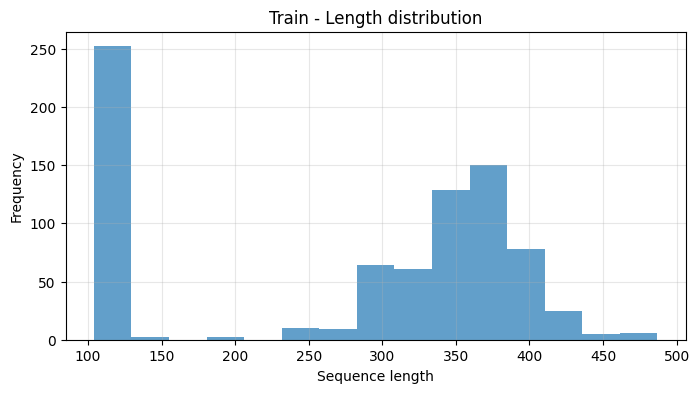


Validation:
	Minimum length: 103
	Maximum length: 475
	Average length: 262.31


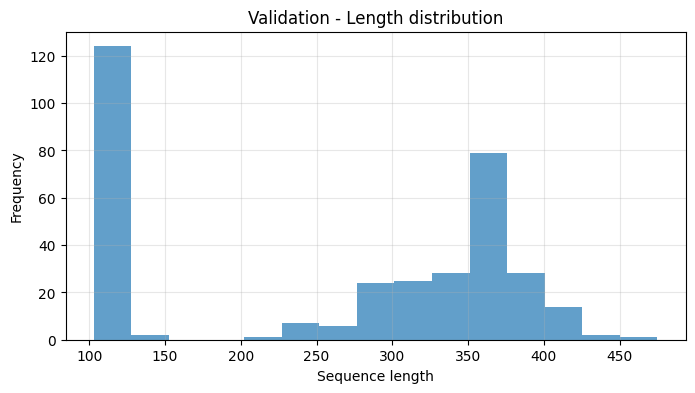


Test (tRNA):
	Minimum length: 55
	Maximum length: 94
	Average length: 78.19


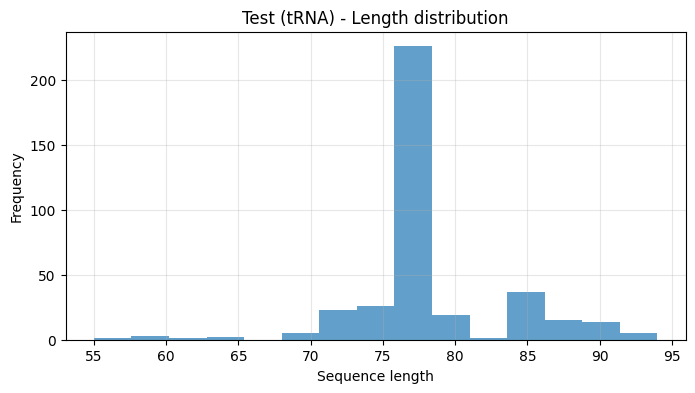


✅ FOLD 1 ready!
Available variables: 'train', 'val', 'test'
You can continue with your code using these variables.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# FOLD 1: Train with ['5sRNA', 'RNAseP', 'tmRNA'] - Test with ['tRNA']

print("="*60)
print("FOLD 1: Test with tRNA family")
print("="*60)

# Configuration
my_file_en = "ArchiveII_gt.txt"
my_file_es = "ArchiveII_probknot.txt"

family_sizes = [378, 378, 378, 378]
family_names = ['tRNA', '5sRNA', 'RNAseP', 'tmRNA']

# Read files
with open(my_file_es, encoding="utf8") as fp:
    de_list = fp.readlines()
with open(my_file_en, encoding="utf8") as fp:
    en_list = fp.readlines()

# Extract data by family
def get_family_data(family_index):
    start = sum(family_sizes[:family_index])
    end = start + family_sizes[family_index]
    return list(zip(de_list[start:end], en_list[start:end]))

# FOLD 1: Test with tRNA (index 0)
test_family_idx = 0
test_family_name = family_names[test_family_idx]
training_families = [family_names[i] for i in range(len(family_names)) if i != test_family_idx]

print(f"TEST family: {test_family_name}")
print(f"TRAINING families: {training_families}")

# Get test data (entire tRNA family)
test = get_family_data(test_family_idx)

# Get training data (5sRNA, RNAseP, tmRNA families)
training_data = []
for i in range(len(family_names)):
    if i != test_family_idx:
        family_data = get_family_data(i)
        training_data.extend(family_data)

# Split training_data into train and validation
random.seed(1234)
random.shuffle(training_data)

total_training = len(training_data)
train_size = int(total_training * 0.7)

train = training_data[:train_size]
val = training_data[train_size:]

print(f"\nFinal data distribution:")
print(f"\ttrain: {len(train)} samples")
print(f"\tval: {len(val)} samples")
print(f"\ttest ({test_family_name}): {len(test)} samples")

# Sequence length analysis
def analyze_lengths(data, dataset_name):
    lengths = [len(de) for de, en in data]
    print(f"\n{dataset_name}:")
    print(f"\tMinimum length: {min(lengths)}")
    print(f"\tMaximum length: {max(lengths)}")
    print(f"\tAverage length: {np.mean(lengths):.2f}")

    plt.figure(figsize=(8, 4))
    plt.hist(lengths, bins=15, alpha=0.7)
    plt.title(f"{dataset_name} - Length distribution")
    plt.xlabel("Sequence length")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

analyze_lengths(train, "Train")
analyze_lengths(val, "Validation")
analyze_lengths(test, f"Test ({test_family_name})")

print(f"\n✅ FOLD 1 ready!")
print(f"Available variables: 'train', 'val', 'test'")
print(f"You can continue with your code using these variables.")

### Sanity check: pairwise sequence length consistency

This block performs a simple consistency check to verify that:

- All paired elements in the training, validation, and test datasets have matching sequence lengths.
- Specifically, for each tuple `(x, y)` in the datasets, it ensures that `len(x) == len(y)`.

An assertion error is raised if any inconsistency is detected.

Finally, a random example tuple from the validation set is printed for manual inspection.

> These checks help ensure that input-output pairs are correctly aligned before training the model.

In [ ]:
# Verify train
for idx, (x, y) in enumerate(train):
    assert len(x) == len(y), f"Error in train[{idx}]: len(x)={len(x)} != len(y)={len(y)}"

# Verify val
for idx, (x, y) in enumerate(val):
    assert len(x) == len(y), f"Error in val[{idx}]: len(x)={len(x)} != len(y)={len(y)}"

# Verify test
if 'test' in locals() or 'test' in globals():
    for idx, (x, y) in enumerate(test):
        assert len(x) == len(y), f"Error in test[{idx}]: len(x)={len(x)} != len(y)={len(y)}"

# Print example
print("Example of a training tuple:")
print(val[68])

Example of a training tuple:
('PIRRQIIPLJJIVVVIWWYRWY313WRWPWQPWWRYQYPVIIKLHJKKPLKKJKIPIRYWQVRRWYISPPVIVIPIIIVPIVIVPPVVSPVVVVVHKJJILKHLPVPISVPIRYWWQSSVPLKKKJIISRWRYWWRWSVVVIIVIIPVKJKKHLKLVYWRWYRIYRWISIIPPKLHPPLHKJKHVPIIIVPPSPIISVWYRVPRRYRWIIPVVIIIIVIPRRWQQVIIRRWYRWSVIRYRWWYRWVVPPKLHSKKJKJKLHKJLPIILLKJJKJHJJPIJHKIHKJKKK688I\n', 'PIPPIQQRSWWIVWWQWWS3243132PWRWQRWWRYQYPVIIKLHJKKRYRRWPIPIKLJHJRRVSIYPRWIVIPIIIVPIVIWRRWWYRWWWVVIPVVISPISRWRQSVPIRYWWQSSVPLKKKJIISRWRYWWRWSVVVIIVIIPVKJKKHLKLVLJKJSPISPVISIIKKKLHKKLIPJKIVPIIIVPKLPHILJJLKJKKKLKVIIRWWQIIIVIRRRWQIVIIRRWS7686578KJJLKJJJPPPSILKKJPVPSIPVSPIISSPVVPVIVVPIVIPIIKVPKKJLLI\n')


### Save datasets to files

This block exports the processed datasets into plain text files for subsequent model training, evaluation, and metric computation.

For each dataset (`train`, `val`, `test`), both the input (`tupla[0]`) and target (`tupla[1]`) sequences are written to separate files, with trailing newline characters removed.

A small utility function `save_dataset()` is used to simplify and standardize the file export process.

In [ ]:
def save_dataset(dataset, field_index, output_filename):
    with open(output_filename, "w", encoding="utf8") as f:
        for tupla in dataset:
            f.write(tupla[field_index].strip() + '\n')

### Export data splits to individual files

Each dataset (`train`, `val`, `test`) is exported into separate files:

- `*_prediction_*` files contain the first element of each tuple (index `0`).
- `*_ground_truth_*` or `*_gt*` files contain the second element of each tuple (index `1`).

These files will be used in downstream model training and evaluation stages.

In [ ]:
# Save train files
save_dataset(train, 0, "train_prediction.txt")
save_dataset(train, 1, "train_ground_truth.txt")

# Save val files
save_dataset(val, 0, "val_prediction.txt")
save_dataset(val, 1, "val_ground_truth.txt")

# Save test files
save_dataset(test, 0, "test_probknot.txt")
save_dataset(test, 1, "test_gt.txt")

### Data split inspection

This block prints:

- The number of samples in the training and validation datasets.
- One example tuple from each dataset (`train[0]` and `val[0]`) for manual inspection.

These informal checks help confirm that data splitting and file writing steps were correctly performed.

In [ ]:
print(len(train), len(val))

# Print examples
print("Example of a training tuple:")
print(train[0])
print("Example of a validation tuple:")
print(val[0])

793 341
Example of a training tuple:
('RYWYQWRRWVISIWWYQRRWRIIQQWIVWQRYSVVVPSVVPISVHJLKVIKLLIIPJKLJLPHKKRWWYWRSSIPSIWYQYPRYYRPIPIJHHJHLKKPIISVJKKKKLKJLKLHKKJS\n', 'RYWYQWRRWVISIWWYQRRWRIIIIVQWWQRYSVVVPSVVPISVHJLKVIKLSIIPJKLJLKIKKPWWYWRSSIPSIWYQYRPYYRPIPIJHHJHLKKPIISVJKKKKSKJLKLHKKJS\n')
Example of a validation tuple:
('QRWYQWRRWVISIYWYQRWQRYWQPWQWVRYYSVVVPSVVPISVHHJIKLIKLKHISJLKJLHIKHRWWYRQVVPIPSIRYRYQPYRRPIPIJJHLHJKJPIIIVLJHKKLKJLKLHKLLS\n', 'QRWYQWRRWVISIYWYQRWQRSVIPVQWVRYYSVVVPSVVPISVHHJIPSIKLPIISJLKJLHIKHPWWYRQVVPIPSIRYRYQPYRRPIPIJJHLHJKJPIIIVLJHKKSKJLKLHKLLS\n')


## Tokenization, vocabulary building, and token length analysis

This block performs the following pre-processing steps:

- Defines a custom tokenizer (`SimpleSpacy`) that groups characters according to predefined categories.
- Tokenizes both source (`index=0`) and target (`index=1`) sequences from the combined training and validation datasets.
- Builds token vocabularies for both source and target using `torchtext`'s `build_vocab_from_iterator()`.
- Calculates minimum and maximum tokenized sequence lengths for both source and target data.
- Saves the constructed vocabularies into the file `vocab.pt` for future reuse.
- Computes a recommended padding size (`max_padding`) based on the longest observed sequence length, with a margin of two additional tokens for start and end markers.

These steps are essential for preparing the dataset for model training.

In [ ]:
import torch
from torchtext.vocab import build_vocab_from_iterator

# Removed the '\n' and used for counting tokens 3-9-24 with modified coding (November 2024)

def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index].strip())

def get_token_lengths(data_iter, tokenizer, index):
    max_length = 0
    min_length = float('inf')
    for from_to_tuple in data_iter:
        tokens = tokenizer(from_to_tuple[index].strip())
        length = len(tokens)
        max_length = max(max_length, length)
        min_length = min(min_length, length)
    return max_length, min_length

class SimpleSpacy:
    def __init__(self):
        pass

    def tokenize(self, text):
        text = text.strip()  # Remove leading/trailing whitespace including newlines
        tokens = []
        start = 0
        groups = [('QWRY', 2), ('IVPS', 2), ('HJKL', 2), ('1234', 2), ('5678', 2), ('DFZX', 2), ('BMO0', 2)]

        while start < len(text):
            found_group = False
            for group, min_length in groups:
                if start < len(text) and text[start] in group:
                    end = start + 1
                    while end < len(text) and text[end] in group:
                        end += 1

                    if end - start >= min_length:
                        new_token = text[start:end]
                        if not tokens:
                            tokens.append(new_token)
                        elif tokens[-1] in group:
                            tokens[-1] += new_token
                        else:
                            tokens.append(new_token)

                        start = end
                        found_group = True
                        break

            if not found_group:
                if len(tokens) > 0 and tokens[-1] != ' ':
                    tokens[-1] += text[start]
                elif text[start] != ' ':
                    tokens.append(text[start])
                start += 1

        # Merge single-character tokens with the next token
        i = 0
        while i < len(tokens) - 1:
            if len(tokens[i]) == 1 and tokens[i] != ' ':
                tokens[i+1] = tokens[i] + tokens[i+1]
                tokens.pop(i)
            else:
                i += 1

        return tokens


def build_vocabulary(simple_spacy, data):
    def tokenize_text(text):
        tokens = simple_spacy.tokenize(text)
        print("Yielded tokens:", tokens)
        return tokens

    print("Loading vocabulary...")
    print("Building Vocabulary for both languages...")

    max_src_length, min_src_length = get_token_lengths(data, tokenize_text, index=0)
    vocab_src = build_vocab_from_iterator(
        yield_tokens(data, tokenize_text, index=0),
        min_freq=1,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    max_tgt_length, min_tgt_length = get_token_lengths(data, tokenize_text, index=1)
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(data, tokenize_text, index=1),
        min_freq=1,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    print("Vocabulary building completed.")

    return vocab_src, vocab_tgt, max_src_length, min_src_length, max_tgt_length, min_tgt_length

def load_vocab(simple_spacy, data):
    print("Starting vocabulary loading process...")
    vocab_src, vocab_tgt, max_src_length, min_src_length, max_tgt_length, min_tgt_length = build_vocabulary(simple_spacy, data)

    torch.save((vocab_src, vocab_tgt), "vocab.pt")

    print("Vocabulary saved to 'vocab.pt'.")

    print("Finished.\nVocabulary sizes:")
    print("Vocabulary size for src:", len(vocab_src))
    print("Vocabulary size for tgt:", len(vocab_tgt))
    print(f"Max source token length: {max_src_length}")
    print(f"Min source token length: {min_src_length}")
    print(f"Max target token length: {max_tgt_length}")
    print(f"Min target token length: {min_tgt_length}")

    return vocab_src, vocab_tgt, max_src_length, max_tgt_length

# Main execution
simple_spacy = SimpleSpacy()

print("Starting vocabulary loading process...")
vocab_src, vocab_tgt, max_src_length, max_tgt_length = load_vocab(simple_spacy, train + val)

# Compute max padding
max_padding = max(max_src_length, max_tgt_length) + 2  # +2 for start and end tokens
print(f"Suggested max_padding: {max_padding}")

Starting vocabulary loading process...
Starting vocabulary loading process...
Loading vocabulary...
Building Vocabulary for both languages...
Yielded tokens: ['RYWYQWRRW', 'VISI', 'WWYQRRWR', 'II', 'QQW', 'IV', 'WQRY', 'SVVVPSVVPISV', 'HJLK', 'VI', 'KLL', 'IIP', 'JKLJLP', 'HKK', 'RWWYWR', 'SSIPSI', 'WYQYP', 'RYYR', 'PIPI', 'JHHJHLKK', 'PIISV', 'JKKKKLKJLKLHKKJS']
Yielded tokens: ['RRRRWYRQWQP', 'RQIY', 'VPIVIPSIPIPSPS', 'HLJI', 'LKLJHKLI', 'QRWQYRV', 'WRRRRQQY', 'PPSP', 'KLSLI', 'JJJJK', 'SS', 'QYW', 'IIIS', 'KHL', 'SIVVPIVVIISIISSP', 'RWRQQQ', 'VSVP', 'LLLJKJ', 'PSS', 'RRWYRV', 'WYQQYYW', 'IIP', 'KHHLLHKJKS', 'KJJ', 'SS', 'JHLKJL', 'II', 'RRRYYYP', '1414', 'VSPVSI', 'HHHJJJ', 'PP', 'YRWQYY', 'VISV', 'HHLKJH', 'RRY', 'SII', 'KJJ', 'III', 'RRR', '5878', 'JJJ', 'PIVVP', 'RQRRWWP', 'QWQIYV', 'WQRRRQ', 'IVV', 'RRQYRYWQYW', 'IVPSSPSSPVIPSIVVI', 'KHLKKJHLJL', 'SIII', 'LJJ', 'PI', 'YWYRWQ', 'IISIIPVI', 'LKLHKH', 'IIP', 'JLKHLKLP', 'KKJLLL', 'QRWYRR', 'IV', 'RRRRR', 'SSVIIS', 'LJJJJJJKKJLVJI',

### Vocabulary summary

This block prints a summary of both source (`vocab_src`) and target (`vocab_tgt`) vocabularies:

- The total number of tokens in each vocabulary.
- The first 10 and last 10 tokens (ordered as stored internally).

These summaries serve as simple inspections to verify that vocabularies have been built correctly and to get an idea of the token distribution.

In [ ]:
def print_vocab_summary(vocab, name):
    print(f"Summary of {name}:")
    print(f"Total size: {len(vocab)}")
    print("First 10 elements:")
    for token in list(vocab.get_stoi().keys())[:10]:
        print(token)
    print("...")
    print("Last 10 elements:")
    for token in list(vocab.get_stoi().keys())[-10:]:
        print(token)

print_vocab_summary(vocab_src, "vocab_src")
print("\n")
print_vocab_summary(vocab_tgt, "vocab_tgt")

Summary of vocab_src:
Total size: 19273
First 10 elements:
YYYYYYWQ
YYYYYRQY
YYYYWYYW
YYYYWYQQYR
YYYYRQ
YYYYR
YYYYQRS
YYYWRRWV
YYYWQY
YYYWQRY
...
Last 10 elements:
KKLJKJJJ
WWQWRRWVQ
KJKJHLL
KJKJI
KJKJJK
HKKLL
KJKJJKHJHK
QQRYRRWQRRY
KJLLLJ
KJKJJKJH


Summary of vocab_tgt:
Total size: 14859
First 10 elements:
YYYYYQR
YYYYRYYY
YYYYRWP
YYYYRVYV
YYYRYWI
YYYRRYRW
YYYRQYYYRYY
YYYQRYQQ
YYYQRWWR
YYYQQQYYYQQQ
...
Last 10 elements:
HLHLLLHKKKK
PIPVI
VVSSVPVVSPVPVPPIKV
PIPVIPIPIVISI
PIPVIPIPIVIVI
VVPVSJSR
LKKJJKKJ
PIPVIPIPPVISI
PIPVIVPP
PIQP


### Vocabulary content inspection and token length distribution

This block performs an analysis of the constructed vocabularies (`vocab_src` and `vocab_tgt`):

- Iterates through all tokens and their assigned indices.
- Writes the complete vocabulary contents to separate text files (`vocabulario_src.txt` and `vocabulario_tgt.txt`).
- Computes the distribution of token lengths (in characters).
- Visualizes the token length distribution using histograms.

These analyses provide insights into the structure of the tokenization process and allow verification of vocabulary contents for both source and target sequences.

Elements in vocab_src:
19269: YYYYYYWQ (length: 8)
19267: YYYYYRQY (length: 8)
19264: YYYYWYYW (length: 8)
19262: YYYYWYQQYR (length: 10)
19255: YYYYRQ (length: 6)
19254: YYYYR (length: 5)
19251: YYYYQRS (length: 7)
19240: YYYWRRWV (length: 8)
19238: YYYWQY (length: 6)
19236: YYYWQRY (length: 7)
19229: YYYRYS (length: 6)
19228: YYYRYRYQQQYY (length: 12)
19221: YYYRRYYYYRQV (length: 12)
19214: YYYRRRQRRWYYQQYW (length: 16)
19211: YYYQYYYQYYQQYYYR (length: 16)
19207: YYYQWWYRWWY (length: 11)
19205: YYYQRYYQQYYYYQRYYQQQ (length: 20)
19200: YYWYYRRR (length: 8)
19199: YYWYYQRQYQ (length: 10)
19197: YYWYWYYYW (length: 9)
19196: YYWYWYQQRYYY (length: 12)
19195: YYWYWYQQR (length: 9)
19191: YYWYRYYRYV (length: 10)
19189: YYWYRQV (length: 7)
19185: YYWWYYYQW (length: 9)
19184: YYWWYQYYY (length: 9)
19183: YYWWWYYYW (length: 9)
19182: YYWWWRYRWWWR (length: 12)
19180: YYWWWQRYP (length: 9)
19176: YYWS (length: 4)
19175: YYWRYW (length: 6)
19174: YYWRYRYRQWWRRR (length: 14)
19172: YYWRWS (length:

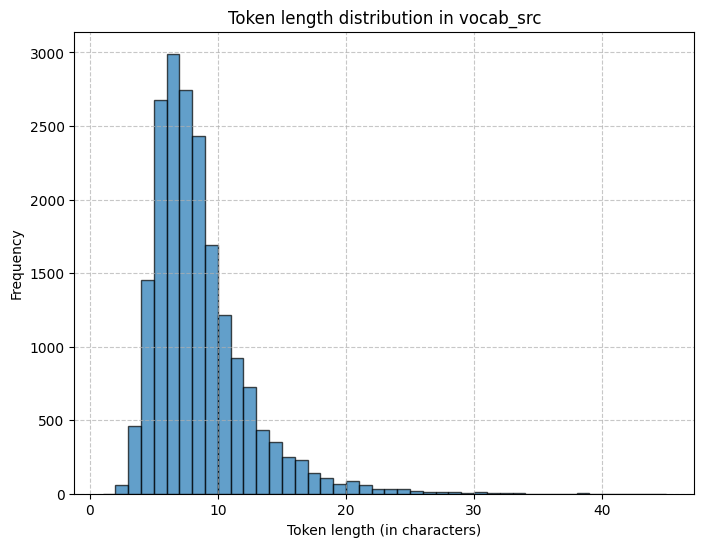



Elements in vocab_tgt:
14852: YYYYYQR (length: 7)
14849: YYYYRYYY (length: 8)
14848: YYYYRWP (length: 7)
14847: YYYYRVYV (length: 8)
14840: YYYRYWI (length: 7)
14838: YYYRRYRW (length: 8)
14835: YYYRQYYYRYY (length: 11)
14832: YYYQRYQQ (length: 8)
14831: YYYQRWWR (length: 8)
14826: YYYQQQYYYQQQ (length: 12)
14821: YYWYWQYWQQQP (length: 12)
14818: YYWYQQYR (length: 8)
14817: YYWYQI (length: 6)
14815: YYWWYQW (length: 7)
14814: YYWWWRQY (length: 8)
14812: YYWWR (length: 5)
14810: YYWV (length: 4)
14808: YYWRRWRR (length: 8)
14807: YYWRRR (length: 6)
14803: YYWQRRWWRQRQ (length: 12)
14802: YYWQRRRRV (length: 9)
14800: YYWPWV (length: 6)
14796: YYRYYYRRWY (length: 10)
14791: YYRYRYQQQYY (length: 11)
14790: YYRYRYQQQYW (length: 11)
14787: YYRYRPR (length: 7)
14785: YYRYQP (length: 6)
14782: YYRVY (length: 5)
14781: YYRRYRR (length: 7)
14779: YYRRWQ (length: 6)
14778: YYRRRYS (length: 7)
14776: YYRRQ (length: 5)
14775: YYRRI (length: 5)
14773: YYRQYP (length: 6)
14772: YYRQS (length: 5)
14

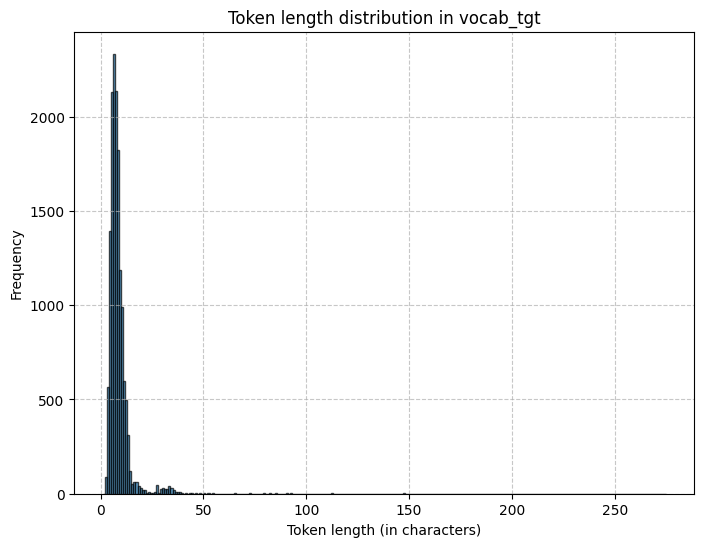

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def print_full_vocab(vocab, name, filename):
    # Open the file for writing
    with open(filename, "w", encoding="utf-8") as f:
        f.write(f"Elements in {name}:\n")
        print(f"Elements in {name}:")

        token_lengths = []  # List to store token lengths

        # Iterate over vocabulary items
        for token, index in vocab.get_stoi().items():
            token_length = len(token)
            token_lengths.append(token_length)

            # Write to file and print on screen
            line = f"{index}: {token} (length: {token_length})"
            f.write(line + "\n")
            print(line)

    # Compute token length distribution
    length_distribution = Counter(token_lengths)

    # Print length distribution on screen
    print("\nToken length distribution:")
    for length, count in sorted(length_distribution.items()):
        print(f"Length: {length}, Count: {count}")

    # Generate histogram
    plt.figure(figsize=(8, 6))
    plt.hist(token_lengths, bins=range(1, max(token_lengths) + 2), edgecolor='black', alpha=0.7)
    plt.title(f"Token length distribution in {name}")
    plt.xlabel("Token length (in characters)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Use of the function
print_full_vocab(vocab_src, "vocab_src", "vocabulario_src.txt")
print("\n")
print_full_vocab(vocab_tgt, "vocab_tgt", "vocabulario_tgt.txt")

### Load saved vocabularies

The source (`vocab_src`) and target (`vocab_tgt`) vocabularies are loaded from the previously saved `vocab.pt` file to be used for model training.

In [ ]:
vocab_src, vocab_tgt = torch.load("vocab.pt")

## DataLoaders and Batching

### Batch collation and padding

This function (`collate_batch`) processes input batches for model training:

- Tokenizes both source and target sequences.
- Adds start-of-sequence (`<s>`) and end-of-sequence (`</s>`) tokens.
- Converts tokenized sequences into tensor representations using the corresponding vocabularies.
- Applies zero-padding to a fixed maximum length (`max_padding`).
- Returns padded batches as stacked tensors ready for model input.

In [ ]:
# Create instances of SimpleSpacy
simple_spacy_es = SimpleSpacy()
simple_spacy_en = SimpleSpacy()

def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=100,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            pad(
                processed_src,
                (0, max_padding - len(processed_src)),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

### DataLoader creation for training and validation

This function (`create_dataloaders`) prepares DataLoaders for both the training and validation sets:

- Applies the previously defined tokenization and collation functions.
- Converts datasets to map-style format to support distributed training if enabled.
- Builds DataLoader instances with optional distributed sampling and batch size control.
- Returns DataLoaders for use in the model training loop.

In [ ]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    simple_spacy_es,
    simple_spacy_en,
    batch_size=8,
    max_padding=100,
    is_distributed=True,
):

    def tokenize_de(text):
        return simple_spacy_es.tokenize(text)

    def tokenize_en(text):
        return simple_spacy_en.tokenize(text)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter = train, val

    train_iter_map = to_map_style_dataset(train_iter)
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

## Model training pipeline

### Model training loop

This function (`train_worker`) executes the main model training procedure:

- Supports both single-GPU and multi-GPU distributed training using PyTorch DDP.
- Builds the model architecture, optimizer, learning rate scheduler, and loss function.
- Prepares DataLoaders for training and validation.
- Iterates over multiple epochs, performing both training and validation at each epoch.
- Records and stores training/validation losses for each epoch.
- Saves model checkpoints and loss history after each epoch.
- Generates and saves a training vs validation loss plot at the end.

This function forms the core model training loop used in this study.

In [ ]:
# Modified code with integrated plot using train and val

def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    simple_spacy_es,
    simple_spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    print("Got to this point(1)!!!")
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    print("Got to this point(2)!!!")
    model.cuda(gpu)
    print("Got to this point(3)!!!")
    module = model
    print("Got to this point(4)!!!")
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)
    print("Got to this point(5)!!!")
    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        simple_spacy_es,
        simple_spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )
    print("Got to this point(6)!!!")
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        loss, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        train_loss = loss.item() if torch.is_tensor(loss) else float(loss)
        train_losses.append(train_loss)
        print(f"Training Loss for Epoch {epoch}: {train_loss}")

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)

        if isinstance(sloss, tuple):
            val_loss = sloss[0].item() if torch.is_tensor(sloss[0]) else float(sloss[0])
        else:
            val_loss = sloss.item() if torch.is_tensor(sloss) else float(sloss)
        val_losses.append(val_loss)
        print(f"Validation Loss for Epoch {epoch}: {val_loss}")

        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

        # Save loss results to JSON
        import json
        with open('training_history.json', 'w') as f:
            json.dump({'train_losses': train_losses, 'val_losses': val_losses}, f)

        # Generate and save the loss plot
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.savefig('loss_plot.png')
        print("Loss plot saved as 'loss_plot.png'")

    return train_losses, val_losses

### Distributed training orchestration

These functions control whether model training is executed in single-GPU or multi-GPU (distributed) mode:

- `train_distributed_model`:  
  - Detects the number of available GPUs.
  - Configures distributed training using PyTorch multiprocessing.
  - Spawns one worker process per GPU to run `train_worker()` in parallel.

- `train_model`:  
  - Acts as a wrapper function.
  - Executes distributed or non-distributed training depending on the value of the `distributed` flag in the provided `config` dictionary.

This design allows flexible switching between single-GPU and multi-GPU setups for scalable training.

In [ ]:
def train_distributed_model(vocab_src, vocab_tgt, spacy_es, spacy_en, config):
    from the_annotated_transformer import train_worker

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_es, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_es, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, simple_spacy_es, simple_spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, simple_spacy_es, simple_spacy_en, config, False
        )

## Model loading and (re-)training logic

This function (`load_trained_model`) performs the following tasks:

- Defines the training configuration hyperparameters, including:
  - batch size
  - learning rate
  - maximum padding
  - number of epochs
  - warm-up steps
  - accumulation steps
  - file prefix for model checkpoints

- Checks whether a trained model file (`multi30k_model_final.pt`) already exists:
  - If not, it triggers model training by calling `train_model()`.
  - If the file exists, it skips training and loads the previously saved model parameters.

- Builds the model architecture and loads the trained weights from disk.

- Returns the trained model instance, ready for evaluation or inference.

This logic allows automatic re-use of previously trained models while still enabling full reproducibility if retraining is required.

In [ ]:
def load_trained_model():
    config = {
        "batch_size": 16,
        "distributed": False,
        "num_epochs": 50,  # EPOCHS
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 100,  # padding
        "warmup": 800,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, simple_spacy_es, simple_spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model

### Conditional model loading for interactive notebook sessions

This block ensures that the model is automatically loaded (or trained if necessary) only when running interactively inside a notebook environment.

The `is_interactive_notebook()` utility function detects whether the current session is running inside Colab or Jupyter.

This design prevents unintended execution when the notebook is imported or executed as part of larger automated pipelines.

In [ ]:
if is_interactive_notebook():
    model = load_trained_model()

Train worker process using GPU: 0 for training
Got to this point(1)!!!



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

Got to this point(2)!!!
Got to this point(3)!!!
Got to this point(4)!!!
Got to this point(5)!!!
Got to this point(6)!!!
[GPU0] Epoch 0 Training ====
Epoch Step:      1 | Accumulation Step:   1 | Loss:   8.36 | Tokens / Sec:   623.4 | Learning Rate: 3.9e-06
Epoch Step:     41 | Accumulation Step:   5 | Loss:   8.16 | Tokens / Sec:  4348.2 | Learning Rate: 8.2e-05
Training Loss for Epoch 0: 8.266253471374512
| ID | GPU | MEM |
------------------
|  0 | 95% | 22% |
[GPU0] Epoch 0 Validation ====
(tensor(8.1467, device='cuda:0'), <__main__.TrainState object at 0x7c33a89ff790>)
Validation Loss for Epoch 0: 8.14669132232666
[GPU0] Epoch 1 Training ====
Epoch Step:      1 | Accumulation Step:   1 | Loss:   8.11 | Tokens / Sec:  4992.5 | Learning Rate: 1.0e-04
Epoch Step:     41 | Accumulation Step:   5 | Loss:   7.92 | Tokens / Sec:  4338.8 | Learning Rate: 1.8e-04
Training Loss for Epoch 1: 8.040382385253906
| ID | GPU | MEM |
------------------
|  0 | 95% | 22% |
[GPU0] Epoch 1 Validation =

KeyboardInterrupt: 

## Training history analysis and loss visualization

### Loss visualization

This block analyzes the training history and generates an annotated loss plot:

- Loads training and validation loss histories from the previously saved `training_history.json` file.
- Prints the first 5 values of both loss series for verification.
- Identifies the epoch corresponding to the minimum validation loss.
- Generates a plot of training and validation loss over epochs.
- Highlights the epoch with the minimum validation loss using a marker and annotation.
- Saves the resulting plot to `loss_plot_with_min.png` for future reference.
- Displays the plot for visual inspection.

This diagnostic plot provides an intuitive summary of model convergence and helps identify potential overfitting or underfitting.

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load training history from JSON file
with open('training_history.json', 'r') as f:
    history = json.load(f)

# Print first few loss values for verification
print("First 5 Training Loss values:", history['train_losses'][:5])
print("First 5 Validation Loss values:", history['val_losses'][:5])

# Find epoch with minimum validation loss
min_val_loss = min(history['val_losses'])
min_val_epoch = history['val_losses'].index(min_val_loss)

print(f"Epoch with minimum validation loss: {min_val_epoch}")
print(f"Minimum validation loss value: {min_val_loss:.4f}")

# Create plot
plt.figure(figsize=(12, 8))
plt.plot(history['train_losses'], label='Training Loss', alpha=0.7)
plt.plot(history['val_losses'], label='Validation Loss', alpha=0.7)

# Mark minimum validation loss point
plt.scatter(min_val_epoch, min_val_loss, color='red', s=100, zorder=5)
plt.annotate(f'Min Val Loss: {min_val_loss:.4f}\nEpoch: {min_val_epoch}',
             (min_val_epoch, min_val_loss),
             xytext=(10, 10),
             textcoords='offset points',
             ha='left',
             va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.ylim(bottom=0)  # Set lower y-axis limit to 0
plt.grid(True, linestyle='--', alpha=0.6)

# Save plot to PNG file
plt.savefig('loss_plot_with_min.png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

### Retrieve filename of the best model checkpoint

Using the previously identified epoch (`min_val_epoch`), this expression generates the filename corresponding to the saved model checkpoint for the best validation performance:

In [ ]:
f"multi30k_model_{min_val_epoch}.pt"

This filename can be used to load the best-performing model for evaluation or inference.